### Initialization

In [1]:
import pandas as pd
import statistics
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
df = pd.read_csv('features_data.csv')
comms = pd.read_csv('comms_data.csv')

# Considering louvain_nx as target
labels = comms['leiden_nx']
df['label'] = labels

# Drop extra column
df.drop(columns = df.columns[[0,1]], axis=1, inplace=True)

For single node features, taking product of the feature values of the same node to create new features.

In [30]:
# Creating product features

new_col_names = ['degree', 'triangles', 'clique_number', 'coreness', 'betweenness', 'closeness', 'harmonic', 'eigenvector' , 'decay', 'pagerank', 'local_clustering_coeff', 'global_clustering_coeff', 'shannon', 'h_index', 'nbd_density', 'RWR', 'LRW']
df2 = pd.DataFrame()

for i in range(0, 33, 2):
    df2[new_col_names[int(i/2)]] = df[df.columns[i]] * df[df.columns[i+1]]
for i in range(34, 53):
    col_name = df.columns[i]
    df2[col_name] = df.iloc[:, i]
df = df2

In [80]:
X = df.drop(columns=['label'], axis=1)
y = df['label']

### Data Exploration

In [82]:
df.isnull().values.any()

False

### Splitting Data

In [98]:
def split(X, y):
    from sklearn.model_selection import train_test_split
    return train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
    
X_train, X_test, y_train, y_test = split(X, y)

### Handling Imbalanced classes
Resampling is done only on training data
- Oversampling
- Undersampling

0    415
1    146
Name: label, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

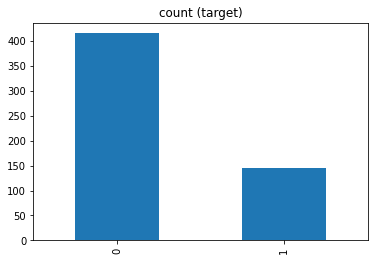

In [84]:
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar', title='count (target)')

In [85]:
from sklearn.utils import resample
#combine them back for resampling
train_data = pd.concat([X_train, y_train], axis=1)
# separate minority and majority classes
negative = train_data[train_data.label==0]
positive = train_data[train_data.label==1]
# upsample minority, sample with replacement, match number in majority class
pos_upsampled = resample(positive, replace=True, n_samples=len(negative), random_state=42)
# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])
# check new class counts
upsampled.label.value_counts()

0    331
1    331
Name: label, dtype: int64

In [86]:
X_train = upsampled.drop('label', axis=1)
y_train = upsampled['label']

### Feature Scaling
Always split before scaling so that test data does not get affected by training data

In [100]:
# # Normalization

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

# Min-Max scaling

def min_max_scale(X_train, X_test):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
    X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)
    return X_train, X_test

X_train, X_test = min_max_scale(X_train, X_test)

### Dimensionality reduction

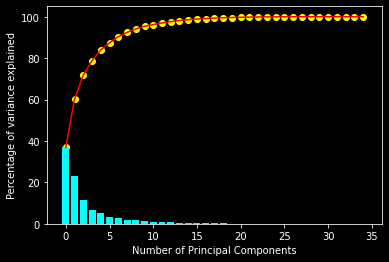

In [13]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = []
for i in range(len(eig_vals)):
    eig_pairs.append( (np.abs(eig_vals[i]), eig_vecs[:,i]))
eig_pairs.sort(key=lambda x: x[0], reverse=True)
total = np.sum(eig_vals)
eig_val = 100 * eig_vals/total
eig_val = sorted(eig_val, reverse=True)

num_feats = X_std.shape[1]
with plt.style.context('dark_background'):
    plt.figure()
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(num_feats), eig_val[:num_feats], color = "aqua")
    plt.plot(range(num_feats), np.cumsum(eig_val[:num_feats]), color = "red")
    plt.scatter(range(num_feats), np.cumsum(eig_val[:num_feats]), color = "yellow")

In [14]:
# Most important features
from sklearn.decomposition import PCA
model = PCA(n_components=15).fit(X_std)
X_pca = model.transform(X_std)
n_pcs= model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = X.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
# imp_features = pd.DataFrame(sorted(dic.items()))
imp_features = [item[1] for item in list(sorted(dic.items()))]
imp_features

['avg_commute_time',
 'hub_promoted',
 'RWR',
 'global_clustering_coeff',
 'triangles',
 'overlap_coeff',
 'L+',
 'leicht_holme_newman',
 'harmonic',
 'are_connected',
 'global_clustering_coeff',
 'betweenness',
 'local_clustering_coeff',
 'betweenness',
 'local_clustering_coeff']

### Feature Selection techniques
- Variance
- Pearson correlation coefficient
- Information gain
- Chi square
- ANOVA F-value
- Recursive Feature Elimination

In [38]:
# Low variance features

from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold = 0)
variance_threshold.fit(X_train)
res = variance_threshold.get_support()
const_columns = X_train.columns[res == False]
# X_train.drop(const_columns, axis = 1)
# X_test.drop(const_columns, axis = 1)
[col for col in const_columns]

['shannon']

In [60]:
# Feature pairs with pearson correlation > 0.9

corr = X.corr().abs().unstack().sort_values(ascending=False).to_frame().reset_index()
corr = corr[corr['level_0'] != corr['level_1']]
top_corr = corr[corr[0] > 0.9]
pairs = set([(top_corr['level_0'].iloc[i], top_corr['level_1'].iloc[i]) for i in range(len(top_corr))])
pairs
# print("No. of features before: ", df.shape[1])

# Dropping columns
# for pair in pairs:
#     cols = df.columns
#     if pair[0] in cols and pair[1] in cols:
#         df.drop(pair[0], axis=1, inplace=True)

# print("No. of features after: ", df.shape[1])
unique = set()
for pair in pairs:
    unique.add(pair[0])
    unique.add(pair[1])
unique

{'L+',
 'LRW',
 'adamic_adar',
 'clique_number',
 'closeness',
 'coreness',
 'cosine_L+',
 'decay',
 'degree',
 'eigenvector',
 'harmonic',
 'hub_depressed',
 'jaccard_index',
 'leicht_holme_newman',
 'matrix_forest_index',
 'nbd_overlap',
 'pref_attachment',
 'resource_allocation',
 'sorenson_dice'}

In [66]:
drops = []
for pair in pairs:
    if pair[0] in drops:
        print(pair[0], ' already dropped')
        continue
    if pair[1] in drops:
        print(pair[1], ' already dropped')
        continue
    corr1 = X[pair[0]].corr(y)
    print('corr of ', pair[0], ' is ', corr1)
    corr2 = X[pair[1]].corr(y)
    print('corr of ', pair[1], ' is ', corr2)
    if corr1 >= corr2: 
        drops.append(pair[1])
        print('Dropped ', pair[1])
    else: 
        drops.append(pair[0])
        print('Dropped ', pair[0])

corr of  jaccard_index  is  0.30690975789234876
corr of  nbd_overlap  is  0.27953520003260224
Dropped  nbd_overlap
corr of  L+  is  0.24971987335282023
corr of  matrix_forest_index  is  0.2692938814278203
Dropped  L+
corr of  cosine_L+  is  0.30380548505341415
corr of  matrix_forest_index  is  0.2692938814278203
Dropped  matrix_forest_index
matrix_forest_index  already dropped
corr of  hub_depressed  is  0.21192205171634415
corr of  leicht_holme_newman  is  0.17779421514013954
Dropped  leicht_holme_newman
corr of  coreness  is  0.05589766361031488
corr of  clique_number  is  0.049676683561731445
Dropped  clique_number
corr of  decay  is  0.017005984426455324
corr of  pref_attachment  is  0.013697615686542888
Dropped  pref_attachment
corr of  degree  is  0.013697615686542888
corr of  LRW  is  0.006816808566596234
Dropped  LRW
corr of  degree  is  0.013697615686542888
corr of  decay  is  0.017005984426455324
Dropped  degree
leicht_holme_newman  already dropped
nbd_overlap  already droppe

{'adamic_adar',
 'closeness',
 'coreness',
 'cosine_L+',
 'decay',
 'hub_depressed',
 'jaccard_index'}

In [79]:
# Features to be kept
new_cols = set(X.columns) - set(drops)
df = df.drop(columns = drops)
df

,triangles,coreness,betweenness,closeness,decay,pagerank,local_clustering_coeff,global_clustering_coeff,shannon,h_index,...,common_neighbors,jaccard_index,hub_promoted,hub_depressed,adamic_adar,overlap_coeff,edge_connectivity,avg_commute_time,cosine_L+,label
0,216,16,685.229167,0.900000,40.00,0.040842,0.064286,0.208608,1.0,20,...,9,0.500000,0.777778,0.437500,6.130717,0.777778,8,0.066405,0.229471,1
1,180,16,198.937500,0.714286,44.00,0.029373,0.100000,0.203804,1.0,25,...,7,0.333333,0.500000,0.312500,2.977248,0.500000,5,0.061748,0.039018,1
2,180,16,198.937500,1.000000,28.00,0.041458,0.100000,0.293306,1.0,20,...,7,0.411765,0.833333,0.312500,3.674792,0.833333,5,0.051262,0.229119,1
3,36,8,44.208333,1.000000,16.00,0.066395,0.100000,0.271739,1.0,15,...,4,0.235294,0.666667,0.125000,1.631587,0.666667,3,0.027576,0.282001,0
4,36,8,44.208333,0.800000,20.00,0.047772,0.100000,0.232919,1.0,15,...,4,0.222222,0.500000,0.125000,1.631587,0.500000,3,0.029231,0.269451,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,0,9,0.000000,0.311688,21.00,0.004016,0.000000,0.251748,1.0,20,...,4,0.285714,0.500000,0.166667,0.974291,0.500000,1,0.038263,0.182668,1
557,0,9,0.000000,0.313364,28.50,0.004169,0.000000,0.185455,1.0,20,...,4,0.210526,0.500000,0.117647,1.023765,0.500000,1,0.040218,0.151622,0
558,0,6,0.000000,0.297521,24.50,0.002948,0.000000,0.128735,1.0,15,...,3,0.176471,0.166667,0.083333,0.352956,0.166667,1,0.043362,0.130269,0
559,0,6,0.000000,0.299120,33.25,0.003061,0.000000,0.094835,1.0,15,...,4,0.190476,0.333333,0.117647,1.312669,0.333333,1,0.048484,0.134191,1


In [101]:
# Information gain

from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)
feature_importances = pd.Series(importances, X_train.columns)

# Plotting
# plt.figure(figsize=(10,8))
# feature_importances.plot(kind='barh')
# plt.show

feature_importances.sort_values()

decay                      0.000000
global_clustering_coeff    0.000000
h_index                    0.000040
closeness                  0.003732
shannon                    0.016791
local_clustering_coeff     0.019047
betweenness                0.020701
are_connected              0.025042
edge_connectivity          0.031643
pagerank                   0.033720
avg_commute_time           0.037045
nbd_density                0.037081
hub_promoted               0.045640
common_triangles           0.047458
hub_depressed              0.048397
overlap_coeff              0.049405
coreness                   0.057861
cosine_L+                  0.058301
common_neighbors           0.066688
jaccard_index              0.068063
triangles                  0.071187
adamic_adar                0.071486
RWR                        0.072979
dtype: float64

In [18]:
# Chi-square test

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
num_feats = 10

chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_train, y_train)
chi_support = chi_selector.get_support()
chi_features = X.loc[:,chi_support].columns.tolist()
chi_features

['are_connected',
 'common_neighbors',
 'jaccard_index',
 'sorenson_dice',
 'hub_promoted',
 'overlap_coeff',
 'nbd_overlap',
 'cosine_L+',
 'L+',
 'matrix_forest_index']

In [19]:
# ANOVA

from sklearn.feature_selection import f_classif
num_feats = 10

f_selector = SelectKBest(f_classif, k=num_feats)
f_selector.fit(X_train, y_train)
f_support = chi_selector.get_support()
f_features = X.loc[:,chi_support].columns.tolist()
f_features

c:\users\shagu\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\users\shagu\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


['are_connected',
 'common_neighbors',
 'jaccard_index',
 'sorenson_dice',
 'hub_promoted',
 'overlap_coeff',
 'nbd_overlap',
 'cosine_L+',
 'L+',
 'matrix_forest_index']

In [20]:
# RFE

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
rfe_feature

Fitting estimator with 35 features.
Fitting estimator with 25 features.
Fitting estimator with 15 features.
10 selected features


['clique_number',
 'coreness',
 'betweenness',
 'sorenson_dice',
 'adamic_adar',
 'nbd_overlap',
 'avg_commute_time',
 'cosine_L+',
 'L+',
 'matrix_forest_index']

### Training models
- Logistic Regression
- K-nearest neighbors
- Support vector classifier
- Naive Bayes
- Random Forest

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

**Performance evaluation metrics:**
<br>
Accuracy: Ratio of correctly predicted observations to the total observations.
<br>`TP+TN/TP+FP+FN+TN`

Precision: Ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate.
<br>`TP/TP+FP`

Recall (Sensitivity): ratio of correctly predicted positive observations to the all observations in actual class.
<br>`TP/TP+FN`

F1 score: weighted average of Precision and Recall. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.
<br>`2*(Recall * Precision) / (Recall + Precision)`

In [22]:
# Cross validation to test model accuracy

def test_model(model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap = 'Blues')
    plt.show()
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    print("Accuracy: ", np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")))
    print("Precision: ", np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring="precision")))
    print("Recall: ", np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")))
    print("F1-score: ", np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")))

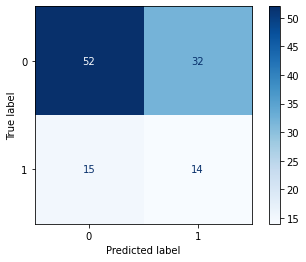

Accuracy:  0.6834415584415584
Precision:  0.7042506646325879
Recall:  0.6403663500678427
F1-score:  0.6676899729990142


In [88]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
steps = [
    ("PCA", PCA(n_components=15)),
    ("model", LogisticRegression(class_weight="balanced")),
]
model = Pipeline(steps=steps)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_model(model)

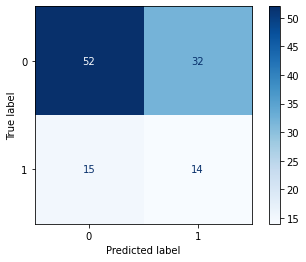

Accuracy:  0.6819434951013899
Precision:  0.7025561141040871
Recall:  0.6403889642695614
F1-score:  0.6668615559925002


In [89]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_model(model)

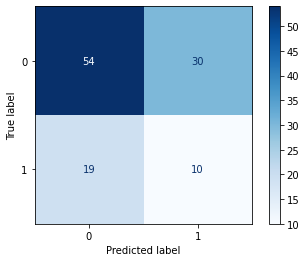

Accuracy:  0.777967646388699
Precision:  0.7682831131857808
Recall:  0.7989145183175034
F1-score:  0.7823012384434815


In [90]:
# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
test_model(model)

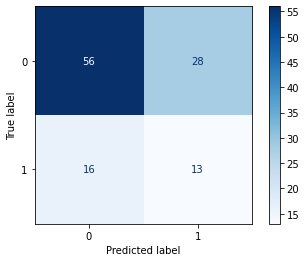

Accuracy:  0.6894907723855093
Precision:  0.7616194172113289
Recall:  0.5572817729534147
F1-score:  0.6407181779478245


In [91]:
# SVC
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
test_model(model)

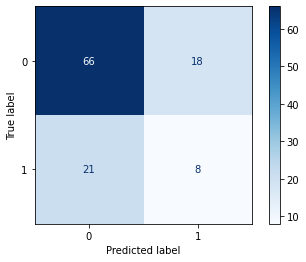

Accuracy:  0.653252449305081
Precision:  0.7379297890891597
Recall:  0.47713704206241525
F1-score:  0.5782408444471564


In [92]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
test_model(model)

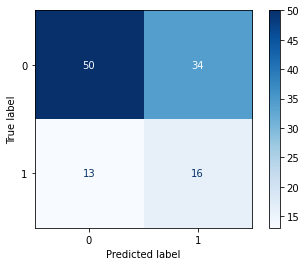

Accuracy:  0.7008658008658009
Precision:  0.7531562227508324
Recall:  0.6041383989145184
F1-score:  0.6679154246405818


In [93]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=2, random_state=42)
model.fit(X_train, y_train)
test_model(model)